In [1]:
# Importing necessary libraries
import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms
from cvtorchvision import cvtransforms
import numpy as np
from models.moco2_module_multiband import MocoV2
from datasets.multilabel_dataset_seco import Multiclef_blind, Subset_blind
import copy

ModuleNotFoundError: No module named 'cvtorchvision'

In [2]:
# Load the pre-trained model
def load_model(model_path, num_labels):
    checkpoint = MocoV2.load_from_checkpoint("/home/plekhano/data/checkpoints/seco-eco_e100.ckpt",
        arch="resnet50", emb_dim=128, moco_k=65536, bands = "B9")
    net = copy.deepcopy(checkpoint.encoder_q)
    net.fc = torch.nn.Linear(2048,num_labels)
    checkpoint = torch.load(model_path)
    net.load_state_dict(checkpoint)
    net.eval()  # Set the model to evaluation mode
    return net
# Define the validation transforms
val_transforms = cvtransforms.Compose([
    cvtransforms.Resize(224),
    #cvtransforms.CenterCrop(224),
    cvtransforms.ToTensor(),
])

# Load the dataset
def load_dataset(data_dir, index_file, label_name, bands, normalize):
    
    return dataset

# Prepare the data loader
def get_data_loader(dataset, batch_size, num_workers, pin_memory):
    val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    return val_loader

# Save predictions to a file
def save_predictions(predictions, output_file):
    with open(output_file, 'w') as f:
        for patch_id, prediction in enumerate(predictions):
            f.write(f"{patch_id}; {prediction}\n")



In [ ]:
import pandas as pd

df = pd.read_csv("/home/plekhano/s2/clef_blind/checked_locations.csv", header = None)
df.columns = ["ind", "lon", "lat", "success"]
df.head()

,ind,lon,lat,success
0,3000971,-4.084365,55.894790,2
1,3000799,-4.239881,56.379872,2
2,12078,2.829488,43.027760,2
3,3001121,-3.979427,57.097861,2
4,3000909,-4.123088,57.072510,2


In [23]:
df.shape

(18647, 4)

In [36]:
# Calculating quantiles for the Finnish AGBM task
import rasterio
from os import listdir
import matplotlib.pyplot as plt
import numpy as np

files = listdir("/shares/wegner.ics.uzh/eplekh/BioMassters/train_agbm/")
print(len(files), files[0])

8689 a750a0a1_agbm.tif


In [48]:
x = []
for file in files:
    agbm = rasterio.open("/shares/wegner.ics.uzh/eplekh/BioMassters/train_agbm/" + file).read(1)
    agbm[agbm > 500] = 500
    x.append(agbm.flatten())
x = np.concatenate(x)
print(x[:20])

[ 54.81  54.81  40.09  40.09  63.6   81.08  81.08 102.31  98.48  98.48
 107.7  107.7   79.11  86.99  86.99  91.23  89.71  89.71  90.63  90.63]


[  0.           0.           0.           4.57000017  21.78000069
  45.63999939  66.72000122  87.45999908 113.27999878 156.8999939
 500.        ]


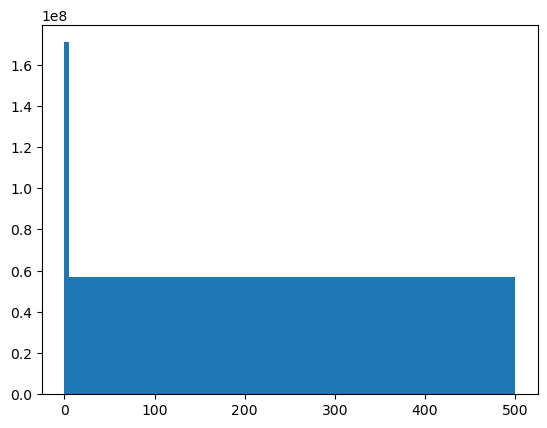

In [49]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
n, bins, patches = plt.hist(x, histedges_equalN(x, 10))
print(bins)

In [50]:
bins = bins[2:]

In [51]:
hists = []
for file in files:
    agbm = rasterio.open("/shares/wegner.ics.uzh/eplekh/BioMassters/train_agbm/" + file).read(1)
    agbm[agbm > 500] = 500
    hists.append(np.histogram(agbm.flatten(), bins)[0])
hists = np.array(hists)
print(hists.mean(axis=0))
print(hists.std(axis=0))

[19656.6573829   6556.6660145   6554.036598    6552.35285994
  6553.86454137  6553.7497986   6554.86695822  6553.80584647]
[12892.79533905  4588.87641158  4168.45561084  3738.40536706
  3253.44718092  3150.59424238  3688.57336959  5495.69911698]


In [53]:
agbm = rasterio.open("/shares/wegner.ics.uzh/eplekh/BioMassters/train_agbm/" + file).read(1)
agbm[agbm > 500] = 500
print(np.histogram(agbm.flatten(), bins)[0]/len(agbm.flatten()))

[0.11451721 0.04689026 0.10923767 0.13174438 0.27612305 0.20436096
 0.09309387 0.02403259]


In [54]:
import pl_bolts
pl_bolts.warnings

ImportError: cannot import name 'LightningLoggerBase' from 'pytorch_lightning.loggers' (/home/jdolli/data/conda/envs/glc23/lib/python3.9/site-packages/pytorch_lightning/loggers/__init__.py)

In [5]:
import ee
ee.Authenticate()

True

In [6]:
from torchvision.datasets.utils import download_and_extract_archive, download_url
download_url("https://storage.googleapis.com/remote_sensing_representations/bigearthnet-test.txt", "./")

HTTPError: HTTP Error 403: Forbidden

In [27]:
df[df.success == 2].to_csv("/home/plekhano/data/sentinel_tiles/sdm/clef_blind_pseudolabel.csv", index=False)

In [24]:
pd.read_csv(index_file).shape

(21513, 3)

In [101]:
 # Define parameters
model_path = '/home/plekhano/code/dsdm/checkpoints/s2_B9_100_resnet50.pt'
data_dir = '/home/plekhano/s2/clef_blind/'
index_file = '/home/plekhano/data/sentinel_tiles/sdm//clef_blind_pseudolabel.csv'
label_name = 'success'
bands = 'B9'
normalize = False
batch_size = 64
num_workers = 32
pin_memory = True
output_file = 'predictions.csv'
num_labels = 2174  # Change this to the actual number of labels

# Load model
model = load_model(model_path, num_labels)

# Load dataset
dataset = Multiclef_blind(root=data_dir, index_file=index_file, label_name=label_name, bands=bands, normalize=normalize)
val_dataset = Subset_blind(dataset, indices=np.arange(len(dataset)), transform=val_transforms)

# Prepare data loader
data_loader = get_data_loader(val_dataset, batch_size, num_workers, pin_memory)

model = model.cuda()

/home/plekhano/miniforge3/envs/geo/lib/python3.13/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f,

/home/plekhano/s2/clef_blind


In [20]:

#predictions = []
#with torch.no_grad():
    #for data in data_loader:
        #inputs = data.cuda() 
        #outputs = model(inputs)
        #_, predicted = torch.max(outputs, 1)
        #predictions.extend(predicted.cpu().numpy())


In [102]:
predictions = []
threshold = 0.5 
with torch.no_grad():
    for data in data_loader:
        inputs = data.cuda()
        outputs = model(inputs)
        # Apply a sigmoid activation to ensure the outputs are between 0 and 1
        outputs = torch.sigmoid(outputs)
        # Convert outputs to binary predictions based on the threshold
        predicted = (outputs > threshold).int()
        # Extend the predictions list with the predicted labels
        predictions.extend(predicted.cpu().numpy())


In [103]:
predictions

[array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(2174,), dtype=int32),
 array([0, 0, 0, ..., 0,

In [6]:
import pandas as pd
ocPa = pd.read_csv('./Presences_Absences_train.csv', header='infer', sep=';')
ocPa = ocPa.groupby(['patchID', 
  'lon',
  'lat',
  'speciesId']).first().reset_index()
dat_ocpa = ocPa[['patchID', 'lon', 'lat', 'speciesId']]
dat_ocpa['label'] = 1
multi_label_ocpa = pd.pivot(dat_ocpa,
                            index=['lat', 'lon', 'patchID'],
                            columns='speciesId',
                            values='label')\
                     .reset_index()\
                     .fillna(0)       
species_id_list = multi_label_ocpa.columns.tolist()[3:]

/sctmp/jdolli/ipykernel_2058847/2935502580.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_ocpa['label'] = 1


In [8]:
print(len(species_id_list))

2174


In [105]:
# Translate predictions to speciesId
translated_predictions = []
for pred_array in predictions:
    species_ids = [species_id_list[idx] for idx, value in enumerate(pred_array) if value == 1]
    translated_predictions.append(species_ids)

In [106]:
translated_predictions

[[4284, 5959, 7021],
 [386, 1333, 1662, 3869, 8419, 8897, 9118],
 [265, 849, 2050, 3589, 4836, 5157, 6361, 7734, 8399],
 [435, 536, 1893, 2188, 4681, 4791, 7367, 7415, 7570, 8914, 9330, 9374, 9823],
 [],
 [729, 1055, 1384, 3097, 3925, 5030, 7519],
 [268,
  386,
  849,
  1005,
  1081,
  1503,
  2188,
  2231,
  3218,
  4051,
  4218,
  5263,
  5685,
  5891,
  6361,
  7276,
  7426,
  7734,
  9196,
  9753,
  9803,
  9823,
  9906],
 [665, 2231, 2855, 3842, 6080, 6731, 7054],
 [449, 1795, 2834, 7137, 7300, 8238, 8510],
 [729, 4725, 5959, 9121, 9752],
 [24,
  386,
  795,
  801,
  876,
  1662,
  1913,
  2854,
  4906,
  5026,
  5263,
  5284,
  5959,
  7426,
  7648,
  8935,
  9075,
  9329,
  9347],
 [1055, 4725, 5959, 9752],
 [8935],
 [980, 4284, 8914, 8999, 9627],
 [24,
  268,
  849,
  1602,
  1725,
  2404,
  3543,
  4051,
  4906,
  5157,
  5263,
  5707,
  5763,
  5959,
  6241,
  6353,
  6361,
  7487,
  7648,
  7787,
  8196,
  8799,
  8987,
  9212,
  9803,
  9906],
 [2557, 6361, 7276, 7605, 7787

In [ ]:
translated_predictions

[[515, 1662, 4182, 4284, 5959, 6837, 7021, 8079],
 [386, 795, 1333, 3869, 4064, 8897, 9118],
 [268, 849, 2050, 2854, 4836, 5157, 6361, 7734],
 [1893, 2188, 3397, 5604, 7367, 7570, 9330],
 [],
 [729, 1055, 1384, 1762, 3097, 3218, 4274, 4725, 5030, 5685, 5959, 7519, 9752],
 [268,
  913,
  1055,
  1081,
  2231,
  2557,
  2834,
  3116,
  3781,
  4051,
  4142,
  4220,
  4304,
  4725,
  5263,
  5404,
  5891,
  6361,
  7082,
  7276,
  7570,
  7734,
  9196,
  9753,
  9906],
 [665, 2231, 2855, 5685, 6080, 7054, 7547, 8395],
 [2834, 4904, 7137, 8238, 8510],
 [729, 5959, 9121, 9752],
 [386, 795, 801, 4906, 5263, 5959, 7648, 8935, 9329, 9347],
 [1055, 5030, 5959, 8935, 9058, 9753],
 [4284, 4634],
 [4284],
 [24,
  265,
  268,
  849,
  1602,
  1725,
  5263,
  5763,
  5959,
  6361,
  7648,
  7787,
  8935,
  9212,
  9803],
 [2557, 7276, 7605, 9509],
 [515, 775, 5959, 9329],
 [268, 417, 783, 2854, 3069, 4291, 4906, 5763, 5773, 5959, 7648, 8935, 9634],
 [268, 795, 801, 1055, 4218, 5030, 8935, 9347, 9906

In [107]:
len(translated_predictions)

18644

In [108]:
# Save predictions
save_predictions(translated_predictions, output_file)
print(f"Predictions saved to {output_file}")

Predictions saved to predictions.csv


In [109]:
pred = pd.read_csv("predictions.csv", header = None, sep = ";")
pred.columns = ["id", "pred"]
pred.head()

,id,pred
0,0,"[4284, 5959, 7021]"
1,1,"[386, 1333, 1662, 3869, 8419, 8897, 9118]"
2,2,"[265, 849, 2050, 3589, 4836, 5157, 6361, 7734..."
3,3,"[435, 536, 1893, 2188, 4681, 4791, 7367, 7415..."
4,4,[]


In [110]:
df = pd.read_csv("/home/plekhano/data/sentinel_tiles/sdm/clef_blind_pseudolabel.csv")
df["pred"] = pred["pred"]
df.head()

,ind,lon,lat,success,pred
0,3000971,-4.084365,55.894790,2,"[4284, 5959, 7021]"
1,3000799,-4.239881,56.379872,2,"[386, 1333, 1662, 3869, 8419, 8897, 9118]"
2,12078,2.829488,43.027760,2,"[265, 849, 2050, 3589, 4836, 5157, 6361, 7734..."
3,3001121,-3.979427,57.097861,2,"[435, 536, 1893, 2188, 4681, 4791, 7367, 7415..."
4,3000909,-4.123088,57.072510,2,[]


In [111]:
out = pd.read_csv("/home/plekhano/data/sentinel_tiles/sdm/clef_test_blind.csv", sep = ";")
out.head()

,Id,datasetName,date,dayOfYear,year,patchID,timeSerieID,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM
0,1,CBNMed,1629064800,228,2021,10125,3988380,1.729607,42.52171,3640762.0,2194746.0,5.0
1,2,CBNMed,1629064800,228,2021,10126,3997090,1.729624,42.52177,3640764.0,2194753.0,4.0
2,3,CBNMed,1629064800,228,2021,10127,4001106,1.729652,42.52197,3640769.0,2194775.0,5.0
3,4,CBNMed,1629064800,228,2021,10129,4004605,1.729671,42.52192,3640770.0,2194769.0,6.0
4,5,CBNMed,1531346400,193,2018,10154,3987660,1.826847,42.57452,3649316.0,2199695.0,0.0


In [112]:
merged = out.merge(df, left_on='patchID', right_on='ind', how='left')
#all(merged.lon_x == merged.lon_y)
merged.head()

,Id,datasetName,date,dayOfYear,year,patchID,timeSerieID,lon_x,lat_x,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,ind,lon_y,lat_y,success,pred
0,1,CBNMed,1629064800,228,2021,10125,3988380,1.729607,42.52171,3640762.0,2194746.0,5.0,10125.0,1.729607,42.52171,2.0,"[1005, 9330]"
1,2,CBNMed,1629064800,228,2021,10126,3997090,1.729624,42.52177,3640764.0,2194753.0,4.0,10126.0,1.729624,42.52177,2.0,"[1005, 5707]"
2,3,CBNMed,1629064800,228,2021,10127,4001106,1.729652,42.52197,3640769.0,2194775.0,5.0,10127.0,1.729652,42.52197,2.0,[]
3,4,CBNMed,1629064800,228,2021,10129,4004605,1.729671,42.52192,3640770.0,2194769.0,6.0,10129.0,1.729671,42.52192,2.0,[9330]
4,5,CBNMed,1531346400,193,2018,10154,3987660,1.826847,42.57452,3649316.0,2199695.0,0.0,10154.0,1.826847,42.57452,2.0,"[6203, 8419, 8987, 9330, 9474]"


In [113]:
np.sum(merged.lon_x == merged.lon_y)

np.int64(22400)

In [114]:
nepred = merged.pred
nepred[:20]

0                                          [1005, 9330]
1                                          [1005, 5707]
2                                                    []
3                                                [9330]
4                        [6203, 8419, 8987, 9330, 9474]
5             [747, 1433, 5325, 5404, 5707, 8741, 9689]
6                        [1433, 4413, 5404, 5707, 9689]
7      [24, 747, 1433, 4413, 4525, 5707, 6241, 8741,...
8                              [1433, 4525, 5707, 9588]
9                                    [4525, 5707, 5806]
10                 [1283, 4313, 4525, 5707, 6361, 9330]
11                                   [1283, 4525, 5707]
12                             [1283, 5404, 5707, 6361]
13                              [515, 5707, 7901, 9588]
14     [99, 173, 1232, 1520, 2802, 3069, 3814, 4218,...
15     [386, 1282, 1913, 2557, 3406, 3814, 5263, 531...
16     [386, 2514, 2557, 3589, 5314, 5707, 5959, 636...
17     [99, 173, 1283, 2802, 3069, 3814, 4284, 4

In [115]:
# Filter out empty lists
nepred = merged['pred'].apply(lambda x: x if x != [] else None).dropna()

# Remove empty lists from consideration
nepred = nepred[nepred.apply(lambda x: x != [])]

# Calculate the mode
mode_value = nepred.mode()

print(mode_value)
   


0     []
Name: pred, dtype: object


In [116]:
nepred.drop_duplicates().shape

(13567,)

In [118]:
from scipy.stats import mode

# Function to compute mode, handling empty lists
def compute_mode(arr):
    if len(arr) == 0:
        return np.nan  # Handle empty case as needed
    arr = np.asarray(arr, dtype=np.float64)  # Ensure array is numeric
    return mode(arr, nan_policy='omit').mode[0]

# Apply the mode computation to each row
mode_values = merged['pred'].apply(compute_mode)




ValueError: could not convert string to float: ' [1005, 9330]'

In [119]:
merged.head()

,Id,datasetName,date,dayOfYear,year,patchID,timeSerieID,lon_x,lat_x,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,ind,lon_y,lat_y,success,pred
0,1,CBNMed,1629064800,228,2021,10125,3988380,1.729607,42.52171,3640762.0,2194746.0,5.0,10125.0,1.729607,42.52171,2.0,"[1005, 9330]"
1,2,CBNMed,1629064800,228,2021,10126,3997090,1.729624,42.52177,3640764.0,2194753.0,4.0,10126.0,1.729624,42.52177,2.0,"[1005, 5707]"
2,3,CBNMed,1629064800,228,2021,10127,4001106,1.729652,42.52197,3640769.0,2194775.0,5.0,10127.0,1.729652,42.52197,2.0,[]
3,4,CBNMed,1629064800,228,2021,10129,4004605,1.729671,42.52192,3640770.0,2194769.0,6.0,10129.0,1.729671,42.52192,2.0,[9330]
4,5,CBNMed,1531346400,193,2018,10154,3987660,1.826847,42.57452,3649316.0,2199695.0,0.0,10154.0,1.826847,42.57452,2.0,"[6203, 8419, 8987, 9330, 9474]"


In [121]:
import ast
merged["Predicted"] = merged["pred"].replace(np.nan, '[]')

# Convert the string representation of lists to actual lists
merged["Predicted"] = merged["Predicted"].apply(ast.literal_eval)

# Now apply the transformation to join list elements with a space
merged["Predicted"] = merged["Predicted"].apply(lambda x: ' '.join(map(str, x)))

In [122]:
merged[["Id", "Predicted"]].head()

,Id,Predicted
0,1,1005 9330
1,2,1005 5707
2,3,
3,4,9330
4,5,6203 8419 8987 9330 9474


In [99]:
merged.iloc[3593:3613,]

,Id,datasetName,date,dayOfYear,year,patchID,timeSerieID,lon_x,lat_x,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,ind,lon_y,lat_y,success,pred,Predicted
3593,3594,CBNMed,1567461600,246,2019,131056,3982814,7.598530,43.974500,4.127898e+06,2.321400e+06,10.0,131056.0,7.598530,43.974500,2.0,"[233, 265, 501, 944, 1005, 3107, 6005, 6107, ...",233 265 501 944 1005 3107 6005 6107 6278 6378 ...
3594,3595,CBNMed,1499119200,185,2017,131057,3995544,7.599306,44.040090,4.128181e+06,2.328666e+06,10.0,131057.0,7.599306,44.040090,2.0,"[307, 849, 1283, 1913, 2050, 4059, 6361, 6574...",307 849 1283 1913 2050 4059 6361 6574 7276 757...
3595,3596,CBNMed,1567461600,246,2019,131067,3983607,7.602510,43.974600,4.128219e+06,2.321401e+06,10.0,131067.0,7.602510,43.974600,2.0,"[265, 814, 1005, 2557, 2802, 3069, 3097, 4059...",265 814 1005 2557 2802 3069 3097 4059 4211 600...
3596,3597,Nat. plant monitoring UK,2017-06-06,157,2017,3000001,4000043,-6.720310,57.378061,3.324687e+06,3.925633e+06,10.0,3000001.0,-6.720310,57.378061,2.0,"[665, 8419, 8999]",665 8419 8999
3597,3598,Nat. plant monitoring UK,2017-06-06,157,2017,3000002,4004440,-6.720240,57.378109,3.324692e+06,3.925636e+06,7.1,3000002.0,-6.720240,57.378109,2.0,"[2855, 9330]",2855 9330
3598,3599,Nat. plant monitoring UK,2021-07-20,201,2021,3000003,3988431,-6.625378,56.609670,3.309834e+06,3.840909e+06,7.1,3000003.0,-6.625378,56.609670,2.0,"[1662, 2802, 3833, 5604, 6837, 7256, 8999, 93...",1662 2802 3833 5604 6837 7256 8999 9330 9993
3599,3600,Nat. plant monitoring UK,2021-08-20,232,2021,3000003,3988431,-6.625378,56.609670,3.309834e+06,3.840909e+06,7.1,3000003.0,-6.625378,56.609670,2.0,"[1662, 2802, 3833, 5604, 6837, 7256, 8999, 93...",1662 2802 3833 5604 6837 7256 8999 9330 9993
3600,3601,Nat. plant monitoring UK,2021-07-20,201,2021,3000004,3988809,-6.624910,56.608520,3.309831e+06,3.840777e+06,7.1,3000004.0,-6.624910,56.608519,2.0,"[615, 5604, 7054, 8999, 9993]",615 5604 7054 8999 9993
3601,3602,Nat. plant monitoring UK,2021-08-20,232,2021,3000004,3988809,-6.624910,56.608519,3.309831e+06,3.840777e+06,7.1,3000004.0,-6.624910,56.608519,2.0,"[615, 5604, 7054, 8999, 9993]",615 5604 7054 8999 9993
3602,3603,Nat. plant monitoring UK,2021-07-20,201,2021,3000005,3986130,-6.619348,56.609711,3.310194e+06,3.840828e+06,7.1,3000005.0,-6.619348,56.609711,2.0,"[1649, 2855, 4182, 6837, 9993]",1649 2855 4182 6837 9993


In [93]:
merged[["Id", "Predicted"]].to_csv("pred_formatted.csv",index = False)

In [46]:
out["pred"] = df.pred[df.ind == out.patchID]

ValueError: Can only compare identically-labeled Series objects